In [110]:
%pylab inline
np.set_printoptions(suppress=True)

import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
%matplotlib inline 
import matplotlib.pyplot as plt
from tqdm import trange

Populating the interactive namespace from numpy and matplotlib


/home/ademattos/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [111]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
len(train_df)

42000

In [114]:
class MnistDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = self.df.iloc[idx,1:].values.astype(np.uint8).reshape((28,28,1))
        label = self.df.iloc[idx,0]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [120]:
dataset = MnistDataset('train.csv', transform=torchvision.transforms.ToTensor())
train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*.85),int(len(dataset)*0.15)])

In [125]:
img, lab = train_set.__getitem__(9)
img.shape, lab

(torch.Size([1, 28, 28]), 9)

In [132]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(val_set, batch_size=65, shuffle=True)

In [127]:
train_iter = iter(train_loader)
type(train_iter)

torch.utils.data.dataloader._SingleProcessDataLoaderIter

In [128]:
images, labels = train_iter.next()
images.size(), labels.size()

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[5 0 2 7 7 0 8 4 2 3 5 5 0 8 7 2 9 8 1 0 3 4 1 2 9 4 8 5 8 1 7 5 0 6 5 7 7\n 7 0 7 5 6 7 6 0 1 5 7 6 2 1 0 7 8 9 9 8 2 9 1 9 8 5 1]')

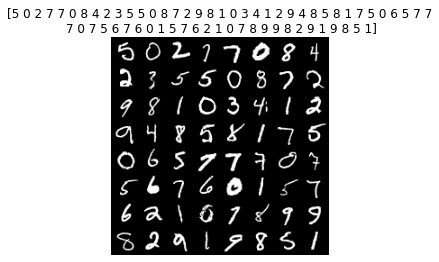

In [129]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy())

In [130]:
#model
class ApdNet(torch.nn.Module):
    def __init__(self):
        super(ApdNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self,x):
        #Max pooling over (2,2) window
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
model = ApdNet()

loss_list, acc_list = [],[]
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
num_epochs = 1
total_step = len(train_loader)
for epoch in (t := trange(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = loss_func(outputs,labels)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total = labels.size(0)
        _, predicted = torch.max(outputs.data,1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct/total)
        
        t.set_description('Epoch [{}/{}], Step [{},{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch+1, num_epochs, i+1, total_step, loss.item(),
                       (correct/total)*100))
    
plt.ylim(-0.1,1.1)
plot(loss_list)
plot(acc_list)
    

Epoch [1/1], Step [382,558], Loss: 0.0431, Accuracy: 98.44%:   0%|          | 0/1 [00:12<?, ?it/s] 

In [145]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test acc: {}%'.format((correct/total)*100))

#save model
torch.save(model.state_dict(), '/home/ademattos/kaggle/mnist/mnist_cnn_model.ckpt')

Test acc: 98.63492063492063%
